## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/


'wget' is not recognized as an internal or external command,
operable program or batch file.


1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [2]:
#Q1
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
file_name="data_000637.txt"
data=pd.read_csv(file_name)
N = 50000
df = data[0:N].copy()
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
49995,1,1,2,3869200664,1103,4
49996,1,1,4,3869200664,1105,14
49997,1,0,59,3869200664,1191,17
49998,1,0,32,3869200664,1191,1


In [10]:
#Q2
x=df['BX_COUNTER'].max()
print("x is:", x)



x is: 3563


In [11]:
 #Q3 & Q4

df["time (ns)"] = df["ORBIT_CNT"]*x*25 + df["BX_COUNTER"]*25 + df["TDC_MEAS"]*25/30
delta_t = (df["time (ns)"].max() - df["time (ns)"].min())*10**(-9)
print("The data taking lasted", delta_t, "seconds")


The data taking lasted 0.044240692500000005 seconds


In [8]:
#Q5
df["HEAD"] = npr.randint(0,2, size=(len(df)))
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,0,0,63,3869200167,2553,28
3,0,0,64,3869200167,2558,19
4,0,0,64,3869200167,2760,25
...,...,...,...,...,...,...
49995,0,1,2,3869200664,1103,4
49996,0,1,4,3869200664,1105,14
49997,1,0,59,3869200664,1191,17
49998,0,0,32,3869200664,1191,1


In [7]:
#Q6
df_one = df[df["HEAD"]==1]
df_one

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
49995,1,1,2,3869200664,1103,4
49996,1,1,4,3869200664,1105,14
49997,1,0,59,3869200664,1191,17
49998,1,0,32,3869200664,1191,1


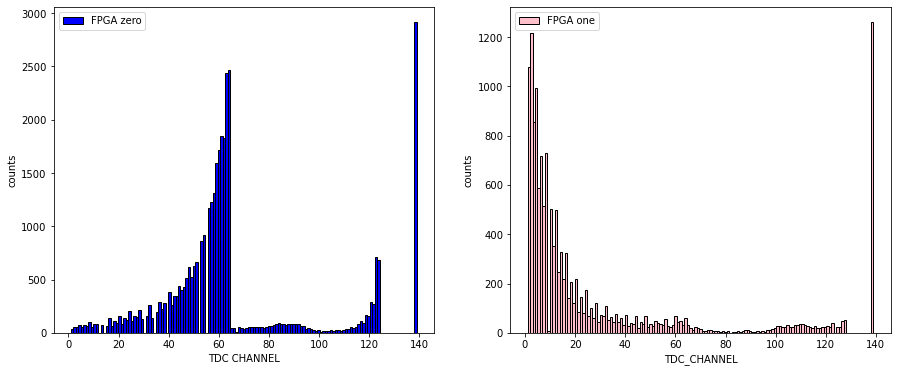

In [6]:
#Q7
f_zero = df[df["FPGA"] == 0]["TDC_CHANNEL"]
f_one = df[df["FPGA"] == 1]["TDC_CHANNEL"]

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.hist(f_zero, bins=f_zero.max(), label="FPGA zero", ec = "black", color = "blue")
plt.xlabel("TDC CHANNEL")
plt.ylabel("counts")
plt.legend()

plt.subplot(1,2,2)
plt.hist(f_one, bins=f_one.max(), label="FPGA one", ec = "black", color = "pink")
plt.xlabel("TDC_CHANNEL")
plt.ylabel("counts")
plt.legend()

plt.show()

In [5]:
#Q8
noisy_channel = df.groupby("TDC_CHANNEL")["FPGA"].count().nlargest(3).index.values
print("The most noisy channels are:", noisy_channel)

The most noisy channels are: [139  64  63]


In [28]:
#Q9
unique_orbits = len(pd.unique(df["ORBIT_CNT"]))
df1= df[df["TDC_CHANNEL"]==139]
unique_orbits_139 = len(pd.unique(df1["ORBIT_CNT"]))

print("There are", unique_orbits, "unique orbits" )
print("There are", unique_orbits_139, "unique orbits from TDC_CHANNEL = 139 ")

There are 498 unique orbits
There are 498 unique orbits from TDC_CHANNEL = 139 
